# GANs Implementation for Dummy Difficulty Levels

## 1. Scenarios and Data
The data was generated from ChatGpt. Assuming the data were generated under the scenario: 2 men played a serious game in arm injury in a recovering period. The game difficulty levels are from 1, 1+, 2, 2+, 3, 3+, 4, 4+, 5. (The advanced level with + sign are indicated as an additional 0.5 value.) 5 rounds will be 1 session. There were 80 sessions in total (400 rounds). Also, assume the 2 players' heights are 173cm and 175cm, weights are 60kg and 58kg.

In [1]:
# import all the libraries
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import random

In [2]:
#import the dataframe
train = pd.read_excel(r'C:\Users\16468\Desktop\new paper\DUMMY.xlsx',header=None)
train = pd.DataFrame(train.values.reshape(80, 5), columns=['round_1', 'round_2', 'round_3','round_4','round_5'])

In [3]:
# check the data
train

,round_1,round_2,round_3,round_4,round_5
0,2.0,3.5,4.0,3.0,3.0
1,2.0,3.5,2.5,1.0,3.5
2,3.0,1.5,2.5,2.5,5.0
3,5.0,4.5,2.5,3.0,5.0
4,3.5,4.0,3.0,4.0,2.5
...,...,...,...,...,...
75,3.0,2.5,5.0,5.0,3.0
76,3.5,3.0,4.5,3.0,5.0
77,2.5,4.0,3.0,5.0,5.0
78,1.5,3.0,1.0,5.0,4.0


In [4]:
train.describe()

,round_1,round_2,round_3,round_4,round_5
count,80.000000,80.000000,80.000000,80.000000,80.000000
mean,3.325000,3.187500,3.481250,3.425000,3.412500
std,1.193601,1.212736,1.362806,1.217229,1.274817
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.375000,2.375000,2.500000,2.500000
50%,3.500000,3.000000,3.750000,3.500000,3.500000
75%,4.500000,4.000000,5.000000,4.500000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


The average data of each round is listed as 3.33, 3.19, 3.48, 3.43, 3.41. We are going to plot the data to see the general trend of difficulty levels for the 5 rounds. 

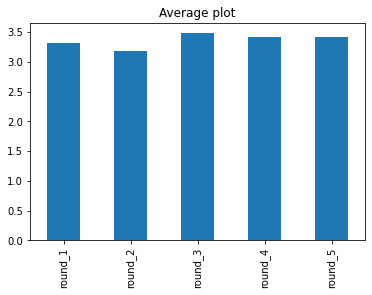

In [5]:
# plot the average
avgs = train.mean()
plot = avgs.plot(kind='bar',title="Average plot")

Ramdomly selected 5 session to plot the trend of each session.

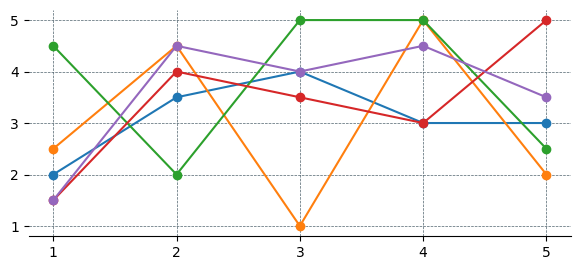

In [6]:
# plot the 5 sessions on the same plot
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = train.iloc[0,:]
Y_2 = train.iloc[9,:]
Y_3 = train.iloc[18,:]
Y_4 = train.iloc[20,:]
Y_5 = train.iloc[35,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# Plot
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

## 2. GANs Generator Set-up

As the data of each session got 5 difficulty levels, therefore, the generator should have 5 elements as output. Now we would like to set the input of the generator includes 4 elements, which are height, weight, injury level and gender.

In [7]:
# Discriminator and Generator submodels
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 250),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(250, 125),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(125, 25),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(25, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output   
    
discriminator = Discriminator()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 25),
            nn.ReLU(),
            nn.Linear(25, 50),
            nn.ReLU(),
            nn.Linear(50, 5),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## 3. Data Preparation and Model Training

While training the model, the training data shoule be loaded in the stand-by status as a tensor. The label of the real data (training data) will be labeled as 0 for the discriminator step training. 

In [8]:
# Create the training tensor
train_data = torch.tensor(train.iloc[:,:].values).to(torch.float32)
# Create the zero labels for the real data
train_labels = torch.zeros(80)
train_set = [(train_data[i], train_labels[i]) for i in range(80)]

In [9]:
# set the training batch size as 10
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# tuning the parameters of the neural networks
lr = 0.001
num_epochs = 500
loss_function = nn.BCEWithLogitsLoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

#### It is important to determine the NOISES.
As we would like to generate the same pattern of future 5 rounds for the people with the similar situation, including the information of height, weight, gender as well as the injury status, the "noises" should be set as the specific range of data. Here, we are going to create some "noises" with height in range 1.70-1.75m, weight in range 5.5-6.5 (*10kg), injury status in level 2 and 3, gender only for male, indicate as 1.

The fake data will start with the "noises" and the data will be trained for those players with "noises" in that range

In [10]:
a=[[1.73,5.6,2,1],[1.70,6.1,3,1],[1.72,5.5,2,1],[1.72,5.8,2,1],[1.72,5.6,2,1],
   [1.75,5.8,3,1],[1.71,6.2,2,1],[1.70,6.2,2,1],[1.71,6.3,3,1],[1.75,6.3,3,1],
   [1.70,5.5,2,1],[1.72,6.3,3,1],[1.72,6.5,3,1],[1.73,6.1,2,1],[1.72,6.2,2,1],
   [1.72,5.6,3,1],[1.73,6.2,2,1],[1.71,5.6,2,1],[1.70,5.9,3,1],[1.72,5.9,2,1],
   [1.74,5.9,2,1],[1.74,6.5,3,1],[1.75,5.7,3,1],[1.73,6.3,2,1],[1.74,5.9,3,1],
   [1.73,6.5,3,1],[1.75,5.9,2,1],[1.70,6.3,2,1],[1.71,5.6,3,1],[1.73,6.1,2,1]]

In [11]:
ran=random.sample(a, 5)

In [19]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        
        # THE NOISES
        latent_space_samples = torch.tensor(ran).to(torch.float32)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.tensor(ran).to(torch.float32)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        #if epoch % 10 == 0 and n == batch_size-1:
        print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
Epoch: 0 Loss G.: 0.6931471824645996
Epoch: 0 Loss D.: 0.6931471824645996
E

Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 8 Loss D.: 0.6931471824645996
Epoch: 8 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
Epoch: 9 Loss G.: 0.6931471824645996
Epoch: 9 Loss D.: 0.6931471824645996
E

Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 16 Loss D.: 0.6931471824645996
Epoch: 16 Loss G.: 0.6931471824645996
Epoch: 17 Loss D.: 0.6931471824645996
Epoch: 17 Loss G.: 0.6931471824645996
Epoch: 17 Loss D.: 0.6931471824645996
Epoch: 17 Loss G.: 0.6931471824645996
Epoch: 17 Lo

Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 24 Loss D.: 0.6931471824645996
Epoch: 24 Loss G.: 0.6931471824645996
Epoch: 25 Lo

Epoch: 31 Loss G.: 0.6931471824645996
Epoch: 31 Loss D.: 0.6931471824645996
Epoch: 31 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Loss G.: 0.6931471824645996
Epoch: 32 Loss D.: 0.6931471824645996
Epoch: 32 Lo

Epoch: 39 Loss D.: 0.6931471824645996
Epoch: 39 Loss G.: 0.6931471824645996
Epoch: 39 Loss D.: 0.6931471824645996
Epoch: 39 Loss G.: 0.6931471824645996
Epoch: 39 Loss D.: 0.6931471824645996
Epoch: 39 Loss G.: 0.6931471824645996
Epoch: 39 Loss D.: 0.6931471824645996
Epoch: 39 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Loss D.: 0.6931471824645996
Epoch: 40 Loss G.: 0.6931471824645996
Epoch: 40 Lo

Epoch: 47 Loss D.: 0.6931471824645996
Epoch: 47 Loss G.: 0.6931471824645996
Epoch: 47 Loss D.: 0.6931471824645996
Epoch: 47 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Loss D.: 0.6931471824645996
Epoch: 48 Loss G.: 0.6931471824645996
Epoch: 48 Lo

Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Loss D.: 0.6931471824645996
Epoch: 56 Loss G.: 0.6931471824645996
Epoch: 56 Lo

Epoch: 63 Loss G.: 0.6931471824645996
Epoch: 63 Loss D.: 0.6931471824645996
Epoch: 63 Loss G.: 0.6931471824645996
Epoch: 63 Loss D.: 0.6931471824645996
Epoch: 63 Loss G.: 0.6931471824645996
Epoch: 63 Loss D.: 0.6931471824645996
Epoch: 63 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Loss G.: 0.6931471824645996
Epoch: 64 Loss D.: 0.6931471824645996
Epoch: 64 Lo

Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 71 Loss D.: 0.6931471824645996
Epoch: 71 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Loss D.: 0.6931471824645996
Epoch: 72 Loss G.: 0.6931471824645996
Epoch: 72 Lo

Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 79 Loss D.: 0.6931471824645996
Epoch: 79 Loss G.: 0.6931471824645996
Epoch: 80 Loss D.: 0.6931471824645996
Epoch: 80 Loss G.: 0.6931471824645996
Epoch: 80 Loss D.: 0.6931471824645996
Epoch: 80 Loss G.: 0.6931471824645996
Epoch: 80 Loss D.: 0.6931471824645996
Epoch: 80 Lo

Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Loss D.: 0.6931471824645996
Epoch: 87 Loss G.: 0.6931471824645996
Epoch: 87 Lo

Epoch: 94 Loss G.: 0.6931471824645996
Epoch: 94 Loss D.: 0.6931471824645996
Epoch: 94 Loss G.: 0.6931471824645996
Epoch: 94 Loss D.: 0.6931471824645996
Epoch: 94 Loss G.: 0.6931471824645996
Epoch: 94 Loss D.: 0.6931471824645996
Epoch: 94 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Loss G.: 0.6931471824645996
Epoch: 95 Loss D.: 0.6931471824645996
Epoch: 95 Lo

Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 102 Loss D.: 0.6931471824645996
Epoch: 102 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.6931471824645996
Epoch: 103 Loss D.: 0.6931471824645996
Epoch: 103 Loss G.: 0.693

Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.6931471824645996
Epoch: 110 Loss D.: 0.6931471824645996
Epoch: 110 Loss G.: 0.693

Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 118 Loss D.: 0.6931471824645996
Epoch: 118 Loss G.: 0.6931471824645996
Epoch: 119 Loss D.: 0.6931471824645996
Epoch: 119 Loss G.: 0.6931471824645996
Epoch: 119 Loss D.: 0.693

Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 126 Loss D.: 0.6931471824645996
Epoch: 126 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.6931471824645996
Epoch: 127 Loss D.: 0.6931471824645996
Epoch: 127 Loss G.: 0.693

Epoch: 134 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.6931471824645996
Epoch: 135 Loss G.: 0.6931471824645996
Epoch: 135 Loss D.: 0.693

Epoch: 142 Loss D.: 0.6931471824645996
Epoch: 142 Loss G.: 0.6931471824645996
Epoch: 142 Loss D.: 0.6931471824645996
Epoch: 142 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.6931471824645996
Epoch: 143 Loss D.: 0.6931471824645996
Epoch: 143 Loss G.: 0.693

Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 150 Loss D.: 0.6931471824645996
Epoch: 150 Loss G.: 0.6931471824645996
Epoch: 151 Loss D.: 0.6931471824645996
Epoch: 151 Loss G.: 0.6931471824645996
Epoch: 151 Loss D.: 0.6931471824645996
Epoch: 151 Loss G.: 0.6931471824645996
Epoch: 151 Loss D.: 0.6931471824645996
Epoch: 151 Loss G.: 0.6931471824645996
Epoch: 151 Loss D.: 0.6931471824645996
Epoch: 151 Loss G.: 0.6931471824645996
Epoch: 151 Loss D.: 0.6931471824645996
Epoch: 151 Loss G.: 0.693

Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 158 Loss D.: 0.6931471824645996
Epoch: 158 Loss G.: 0.6931471824645996
Epoch: 159 Loss D.: 0.6931471824645996
Epoch: 159 Loss G.: 0.693

Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 166 Loss D.: 0.6931471824645996
Epoch: 166 Loss G.: 0.6931471824645996
Epoch: 167 Loss D.: 0.6931471824645996
Epoch: 167 Loss G.: 0.6931471824645996
Epoch: 167 Loss D.: 0.6931471824645996
Epoch: 167 Loss G.: 0.693

Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.6931471824645996
Epoch: 174 Loss G.: 0.6931471824645996
Epoch: 174 Loss D.: 0.693

Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 182 Loss D.: 0.6931471824645996
Epoch: 182 Loss G.: 0.6931471824645996
Epoch: 183 Loss D.: 0.6931471824645996
Epoch: 183 Loss G.: 0.6931471824645996
Epoch: 183 Loss D.: 0.6931471824645996
Epoch: 183 Loss G.: 0.6931471824645996
Epoch: 183 Loss D.: 0.6931471824645996
Epoch: 183 Loss G.: 0.6931471824645996
Epoch: 183 Loss D.: 0.6931471824645996
Epoch: 183 Loss G.: 0.6931471824645996
Epoch: 183 Loss D.: 0.6931471824645996
Epoch: 183 Loss G.: 0.693

Epoch: 190 Loss D.: 0.6931471824645996
Epoch: 190 Loss G.: 0.6931471824645996
Epoch: 190 Loss D.: 0.6931471824645996
Epoch: 190 Loss G.: 0.6931471824645996
Epoch: 190 Loss D.: 0.6931471824645996
Epoch: 190 Loss G.: 0.6931471824645996
Epoch: 190 Loss D.: 0.6931471824645996
Epoch: 190 Loss G.: 0.6931471824645996
Epoch: 190 Loss D.: 0.6931471824645996
Epoch: 190 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.6931471824645996
Epoch: 191 Loss D.: 0.6931471824645996
Epoch: 191 Loss G.: 0.693

Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.6931471824645996
Epoch: 198 Loss D.: 0.6931471824645996
Epoch: 198 Loss G.: 0.693

Epoch: 205 Loss D.: 0.6931471824645996
Epoch: 205 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.6931471824645996
Epoch: 206 Loss D.: 0.6931471824645996
Epoch: 206 Loss G.: 0.693

Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 213 Loss D.: 0.6931471824645996
Epoch: 213 Loss G.: 0.6931471824645996
Epoch: 214 Loss D.: 0.6931471824645996
Epoch: 214 Loss G.: 0.6931471824645996
Epoch: 214 Loss D.: 0.6931471824645996
Epoch: 214 Loss G.: 0.6931471824645996
Epoch: 214 Loss D.: 0.6931471824645996
Epoch: 214 Loss G.: 0.6931471824645996
Epoch: 214 Loss D.: 0.6931471824645996
Epoch: 214 Loss G.: 0.6931471824645996
Epoch: 214 Loss D.: 0.6931471824645996
Epoch: 214 Loss G.: 0.693

Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.6931471824645996
Epoch: 221 Loss D.: 0.6931471824645996
Epoch: 221 Loss G.: 0.693

Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 228 Loss D.: 0.6931471824645996
Epoch: 228 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.6931471824645996
Epoch: 229 Loss D.: 0.6931471824645996
Epoch: 229 Loss G.: 0.693

Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.6931471824645996
Epoch: 236 Loss D.: 0.6931471824645996
Epoch: 236 Loss G.: 0.693

Epoch: 243 Loss G.: 0.6931471824645996
Epoch: 243 Loss D.: 0.6931471824645996
Epoch: 243 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.6931471824645996
Epoch: 244 Loss G.: 0.6931471824645996
Epoch: 244 Loss D.: 0.693

Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 251 Loss D.: 0.6931471824645996
Epoch: 251 Loss G.: 0.6931471824645996
Epoch: 252 Loss D.: 0.6931471824645996
Epoch: 252 Loss G.: 0.6931471824645996
Epoch: 252 Loss D.: 0.6931471824645996
Epoch: 252 Loss G.: 0.6931471824645996
Epoch: 252 Loss D.: 0.6931471824645996
Epoch: 252 Loss G.: 0.6931471824645996
Epoch: 252 Loss D.: 0.6931471824645996
Epoch: 252 Loss G.: 0.693

Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.6931471824645996
Epoch: 259 Loss D.: 0.6931471824645996
Epoch: 259 Loss G.: 0.693

Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.6931471824645996
Epoch: 267 Loss D.: 0.6931471824645996
Epoch: 267 Loss G.: 0.693

Epoch: 274 Loss D.: 0.6931471824645996
Epoch: 274 Loss G.: 0.6931471824645996
Epoch: 274 Loss D.: 0.6931471824645996
Epoch: 274 Loss G.: 0.6931471824645996
Epoch: 274 Loss D.: 0.6931471824645996
Epoch: 274 Loss G.: 0.6931471824645996
Epoch: 274 Loss D.: 0.6931471824645996
Epoch: 274 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.6931471824645996
Epoch: 275 Loss D.: 0.6931471824645996
Epoch: 275 Loss G.: 0.693

Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.6931471824645996
Epoch: 283 Loss D.: 0.6931471824645996
Epoch: 283 Loss G.: 0.693

Epoch: 290 Loss D.: 0.6931471824645996
Epoch: 290 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.6931471824645996
Epoch: 291 Loss D.: 0.6931471824645996
Epoch: 291 Loss G.: 0.693

Epoch: 298 Loss D.: 0.6931471824645996
Epoch: 298 Loss G.: 0.6931471824645996
Epoch: 298 Loss D.: 0.6931471824645996
Epoch: 298 Loss G.: 0.6931471824645996
Epoch: 298 Loss D.: 0.6931471824645996
Epoch: 298 Loss G.: 0.6931471824645996
Epoch: 298 Loss D.: 0.6931471824645996
Epoch: 298 Loss G.: 0.6931471824645996
Epoch: 298 Loss D.: 0.6931471824645996
Epoch: 298 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.6931471824645996
Epoch: 299 Loss D.: 0.6931471824645996
Epoch: 299 Loss G.: 0.693

Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 306 Loss D.: 0.6931471824645996
Epoch: 306 Loss G.: 0.6931471824645996
Epoch: 307 Loss D.: 0.6931471824645996
Epoch: 307 Loss G.: 0.6931471824645996
Epoch: 307 Loss D.: 0.6931471824645996
Epoch: 307 Loss G.: 0.6931471824645996
Epoch: 307 Loss D.: 0.6931471824645996
Epoch: 307 Loss G.: 0.693

Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 314 Loss D.: 0.6931471824645996
Epoch: 314 Loss G.: 0.6931471824645996
Epoch: 315 Loss D.: 0.6931471824645996
Epoch: 315 Loss G.: 0.6931471824645996
Epoch: 315 Loss D.: 0.6931471824645996
Epoch: 315 Loss G.: 0.6931471824645996
Epoch: 315 Loss D.: 0.6931471824645996
Epoch: 315 Loss G.: 0.693

Epoch: 321 Loss D.: 0.6931471824645996
Epoch: 321 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.6931471824645996
Epoch: 322 Loss D.: 0.6931471824645996
Epoch: 322 Loss G.: 0.693

Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 329 Loss D.: 0.6931471824645996
Epoch: 329 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.6931471824645996
Epoch: 330 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.6931471824645996
Epoch: 330 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.6931471824645996
Epoch: 330 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.6931471824645996
Epoch: 330 Loss G.: 0.6931471824645996
Epoch: 330 Loss D.: 0.6931471824645996
Epoch: 330 Loss G.: 0.693

Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.6931471824645996
Epoch: 337 Loss G.: 0.6931471824645996
Epoch: 337 Loss D.: 0.693

Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 344 Loss D.: 0.6931471824645996
Epoch: 344 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.6931471824645996
Epoch: 345 Loss D.: 0.6931471824645996
Epoch: 345 Loss G.: 0.693

Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 352 Loss D.: 0.6931471824645996
Epoch: 352 Loss G.: 0.6931471824645996
Epoch: 353 Loss D.: 0.6931471824645996
Epoch: 353 Loss G.: 0.6931471824645996
Epoch: 353 Loss D.: 0.6931471824645996
Epoch: 353 Loss G.: 0.6931471824645996
Epoch: 353 Loss D.: 0.6931471824645996
Epoch: 353 Loss G.: 0.6931471824645996
Epoch: 353 Loss D.: 0.6931471824645996
Epoch: 353 Loss G.: 0.6931471824645996
Epoch: 353 Loss D.: 0.6931471824645996
Epoch: 353 Loss G.: 0.693

Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 360 Loss D.: 0.6931471824645996
Epoch: 360 Loss G.: 0.6931471824645996
Epoch: 361 Loss D.: 0.6931471824645996
Epoch: 361 Loss G.: 0.6931471824645996
Epoch: 361 Loss D.: 0.6931471824645996
Epoch: 361 Loss G.: 0.693

Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.6931471824645996
Epoch: 368 Loss G.: 0.6931471824645996
Epoch: 368 Loss D.: 0.693

Epoch: 375 Loss D.: 0.6931471824645996
Epoch: 375 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.6931471824645996
Epoch: 376 Loss D.: 0.6931471824645996
Epoch: 376 Loss G.: 0.693

Epoch: 383 Loss G.: 0.6931471824645996
Epoch: 383 Loss D.: 0.6931471824645996
Epoch: 383 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.6931471824645996
Epoch: 384 Loss G.: 0.6931471824645996
Epoch: 384 Loss D.: 0.693

Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 391 Loss D.: 0.6931471824645996
Epoch: 391 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.6931471824645996
Epoch: 392 Loss D.: 0.6931471824645996
Epoch: 392 Loss G.: 0.693

Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 399 Loss D.: 0.6931471824645996
Epoch: 399 Loss G.: 0.6931471824645996
Epoch: 400 Loss D.: 0.6931471824645996
Epoch: 400 Loss G.: 0.693

Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.6931471824645996
Epoch: 407 Loss D.: 0.6931471824645996
Epoch: 407 Loss G.: 0.693

Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 414 Loss D.: 0.6931471824645996
Epoch: 414 Loss G.: 0.6931471824645996
Epoch: 415 Loss D.: 0.6931471824645996
Epoch: 415 Loss G.: 0.6931471824645996
Epoch: 415 Loss D.: 0.6931471824645996
Epoch: 415 Loss G.: 0.6931471824645996
Epoch: 415 Loss D.: 0.6931471824645996
Epoch: 415 Loss G.: 0.6931471824645996
Epoch: 415 Loss D.: 0.6931471824645996
Epoch: 415 Loss G.: 0.6931471824645996
Epoch: 415 Loss D.: 0.6931471824645996
Epoch: 415 Loss G.: 0.693

Epoch: 421 Loss D.: 0.6931471824645996
Epoch: 421 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.6931471824645996
Epoch: 422 Loss D.: 0.6931471824645996
Epoch: 422 Loss G.: 0.693

Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 429 Loss D.: 0.6931471824645996
Epoch: 429 Loss G.: 0.6931471824645996
Epoch: 430 Loss D.: 0.6931471824645996
Epoch: 430 Loss G.: 0.6931471824645996
Epoch: 430 Loss D.: 0.6931471824645996
Epoch: 430 Loss G.: 0.6931471824645996
Epoch: 430 Loss D.: 0.6931471824645996
Epoch: 430 Loss G.: 0.6931471824645996
Epoch: 430 Loss D.: 0.693

Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.6931471824645996
Epoch: 437 Loss D.: 0.6931471824645996
Epoch: 437 Loss G.: 0.693

Epoch: 444 Loss D.: 0.6931471824645996
Epoch: 444 Loss G.: 0.6931471824645996
Epoch: 444 Loss D.: 0.6931471824645996
Epoch: 444 Loss G.: 0.6931471824645996
Epoch: 444 Loss D.: 0.6931471824645996
Epoch: 444 Loss G.: 0.6931471824645996
Epoch: 444 Loss D.: 0.6931471824645996
Epoch: 444 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.6931471824645996
Epoch: 445 Loss D.: 0.6931471824645996
Epoch: 445 Loss G.: 0.693

Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 452 Loss D.: 0.6931471824645996
Epoch: 452 Loss G.: 0.6931471824645996
Epoch: 453 Loss D.: 0.6931471824645996
Epoch: 453 Loss G.: 0.6931471824645996
Epoch: 453 Loss D.: 0.6931471824645996
Epoch: 453 Loss G.: 0.6931471824645996
Epoch: 453 Loss D.: 0.6931471824645996
Epoch: 453 Loss G.: 0.6931471824645996
Epoch: 453 Loss D.: 0.6931471824645996
Epoch: 453 Loss G.: 0.693

Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 460 Loss D.: 0.6931471824645996
Epoch: 460 Loss G.: 0.6931471824645996
Epoch: 461 Loss D.: 0.6931471824645996
Epoch: 461 Loss G.: 0.6931471824645996
Epoch: 461 Loss D.: 0.693

Epoch: 467 Loss D.: 0.6931471824645996
Epoch: 467 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.6931471824645996
Epoch: 468 Loss D.: 0.6931471824645996
Epoch: 468 Loss G.: 0.693

Epoch: 475 Loss D.: 0.6931471824645996
Epoch: 475 Loss G.: 0.6931471824645996
Epoch: 475 Loss D.: 0.6931471824645996
Epoch: 475 Loss G.: 0.6931471824645996
Epoch: 475 Loss D.: 0.6931471824645996
Epoch: 475 Loss G.: 0.6931471824645996
Epoch: 475 Loss D.: 0.6931471824645996
Epoch: 475 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.6931471824645996
Epoch: 476 Loss D.: 0.6931471824645996
Epoch: 476 Loss G.: 0.693

Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 483 Loss D.: 0.6931471824645996
Epoch: 483 Loss G.: 0.6931471824645996
Epoch: 484 Loss D.: 0.6931471824645996
Epoch: 484 Loss G.: 0.6931471824645996
Epoch: 484 Loss D.: 0.6931471824645996
Epoch: 484 Loss G.: 0.6931471824645996
Epoch: 484 Loss D.: 0.6931471824645996
Epoch: 484 Loss G.: 0.6931471824645996
Epoch: 484 Loss D.: 0.6931471824645996
Epoch: 484 Loss G.: 0.6931471824645996
Epoch: 484 Loss D.: 0.6931471824645996
Epoch: 484 Loss G.: 0.693

Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 491 Loss D.: 0.6931471824645996
Epoch: 491 Loss G.: 0.6931471824645996
Epoch: 492 Loss D.: 0.6931471824645996
Epoch: 492 Loss G.: 0.6931471824645996
Epoch: 492 Loss D.: 0.6931471824645996
Epoch: 492 Loss G.: 0.693

Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.6931471824645996
Epoch: 499 Loss D.: 0.6931471824645996
Epoch: 499 Loss G.: 0.693

# 4. Result Testing

We are going to use some "noises" within the ranges for the GANs model and create some samples to see the trend of the 5 rounds of difficulty levels, and check the plot to see how different it is from the real data.

In [20]:
# input of noises and generate difficulty levels
latent_space_samples = torch.tensor([[1.75,5.6,2,1], [1.76,6.0,3,1],[1.75,6.5,2,1],[1.70,6.3,3,1],[1.74,6.2,2,1]]).to(torch.float32)
generated_samples = torch.round(generator(latent_space_samples),decimals=1)

In [21]:
# The 5 generated results.
generated_samples

tensor([[0.8000, 3.7000, 1.3000, 6.4000, 2.6000],
        [0.8000, 3.9000, 1.4000, 6.8000, 2.8000],
        [0.9000, 4.2000, 1.4000, 7.2000, 3.0000],
        [0.9000, 4.1000, 1.4000, 7.0000, 2.9000],
        [0.8000, 4.1000, 1.4000, 6.9000, 2.9000]], grad_fn=<RoundBackward1>)

In [22]:
px = pd.DataFrame(generated_samples.detach().numpy()).astype("float")

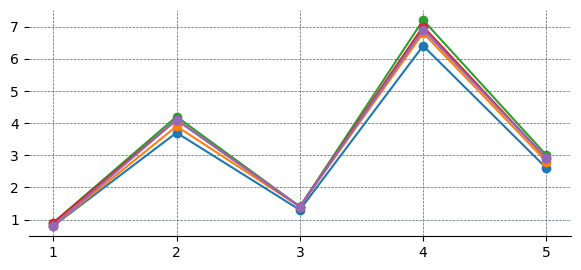

In [23]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = px.iloc[0,:]
Y_2 = px.iloc[1,:]
Y_3 = px.iloc[2,:]
Y_4 = px.iloc[3,:]
Y_5 = px.iloc[4,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# --- The data
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

In [24]:
avgs2 = px.mean()
avgs2

0    0.84
1    4.00
2    1.38
3    6.86
4    2.84
dtype: float64

The average data of each round is listed as 2.60, 4.04, 2.10, 3.46, 4.42. We are going to plot the generated data to see the general trend of difficulty levels for the immitation 5 rounds.

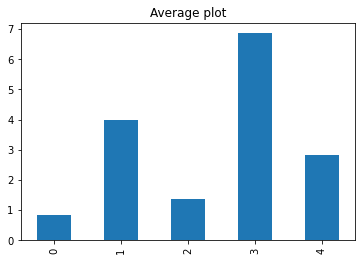

In [25]:
plot = avgs2.plot(kind='bar',title="Average plot")